<!-- Banner Image -->
<center>
    <img src="https://developer-blogs.nvidia.com/wp-content/uploads/2024/07/rag-representation.jpg" width="75%">
</center>

<!-- Links -->
<center>
  <a href="https://www.nvidia.com/en-us/deep-learning-ai/solutions/data-science/workbench/" style="color: #76B900;">NVIDIA AI Workbench</a> •
  <a href="https://docs.nvidia.com/ai-workbench/" style="color: #76B900;">User Documentation</a> •
  <a href="https://forums.developer.nvidia.com/c/ai-data-science/nvidia-ai-workbench/671" style="color: #76B900;"> Problem? Submit a ticket here! </a>
</center>

# Finetune Llama3 using Direct Preference Optimization (DPO) 🤙

Welcome!

This is part 2 of the Llama3 finetuning series. The last notebook was focused on using Supervised Finetuning (SFT) to finetune the Llama3-8B base model. In this one, we're going to take a different approach to finetuning and instead use Direct Preference Optimization. 

#### Help us make this tutorial better! Please provide feedback on the [NVIDIA Developer Forum](https://forums.developer.nvidia.com/c/ai-data-science/nvidia-ai-workbench/671).

A note about running Jupyter Notebooks: Press Shift + Enter to run a cell. A * in the left-hand cell box means the cell is running. A number means it has completed. If your Notebook is acting weird, you can interrupt a too-long process by interrupting the kernel (Kernel tab -> Interrupt Kernel) or even restarting the kernel (Kernel tab -> Restart Kernel). Note restarting the kernel will require you to run everything from the beginning.

Adapted from: [Maxime Labonne](https://twitter.com/maximelabonne)

## Introduction to finetuning using SFT and RLHF

At a high level, finetuning involves taking a pre-trained LLM (like Llama3, Mistral 7b, etc) and controlling its ouput for a certain task. This could be making a model respond in a company-specific manner, generating code in a specific format, or optimizing its performance in an academic field. Most guides online talk about finetuning using Supervised Finetuning (SFT). SFT involves retraining a model on input:output pairs essentially teaching a model what the correct output is given a specific type of input. SFT is extremely useful when you have a large amount of specific labeled data and when the tasks are well defined. Notice how there is no feedback loop in SFT. Once the dataset is created and the finetuning starts, the model does not receive any "feedback" on its performance. It simply learns the output based on the input provided. 

In order to add feedback, we can use a concept called reinforcement learning from human feedback (RLHF). RLHF extends the SFT process by having a separate trained "reward" model which approximates human feedback. This reward model provides scores to each LLM completion and serves as a proxy for a human evaluating an LLM response. This reward model optimizes a fine-tuned models output using the Promixal Policy Algorithm (PPO). PPO revolves around making smaller updates to a models policy in order to improve its performance based on preference. Hoever, PPO is still relatively unstable and difficult to reproduce. Along with that, training a separate reward model requires more data and is computationally expensive!

![RLHF](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*GiEF7F3n-1TlL7_HRJD_OA.png)

## How does DPO improve this

Direct Preference Optimization improves on a lot of the shortcomings of RLHF. Essentially, DPO treats a task as a classification problem. It uses 2 models: the trained model and a copy it called the reference model. During DPO training, the goal is to make sure the trained model outputs higher probabilities for preferred answers and lower probabilities for rejected answers when compared to the reference model. Because the LLM uses itself as a reward model, it is able to align itself without need for a reward model or extensive sampling and hyperparameter tuning. This results in a more stable and less computationally intensive process. 

Note that under the hood, finetuning with DPO is still a 2 stage process: SFT then DPO!

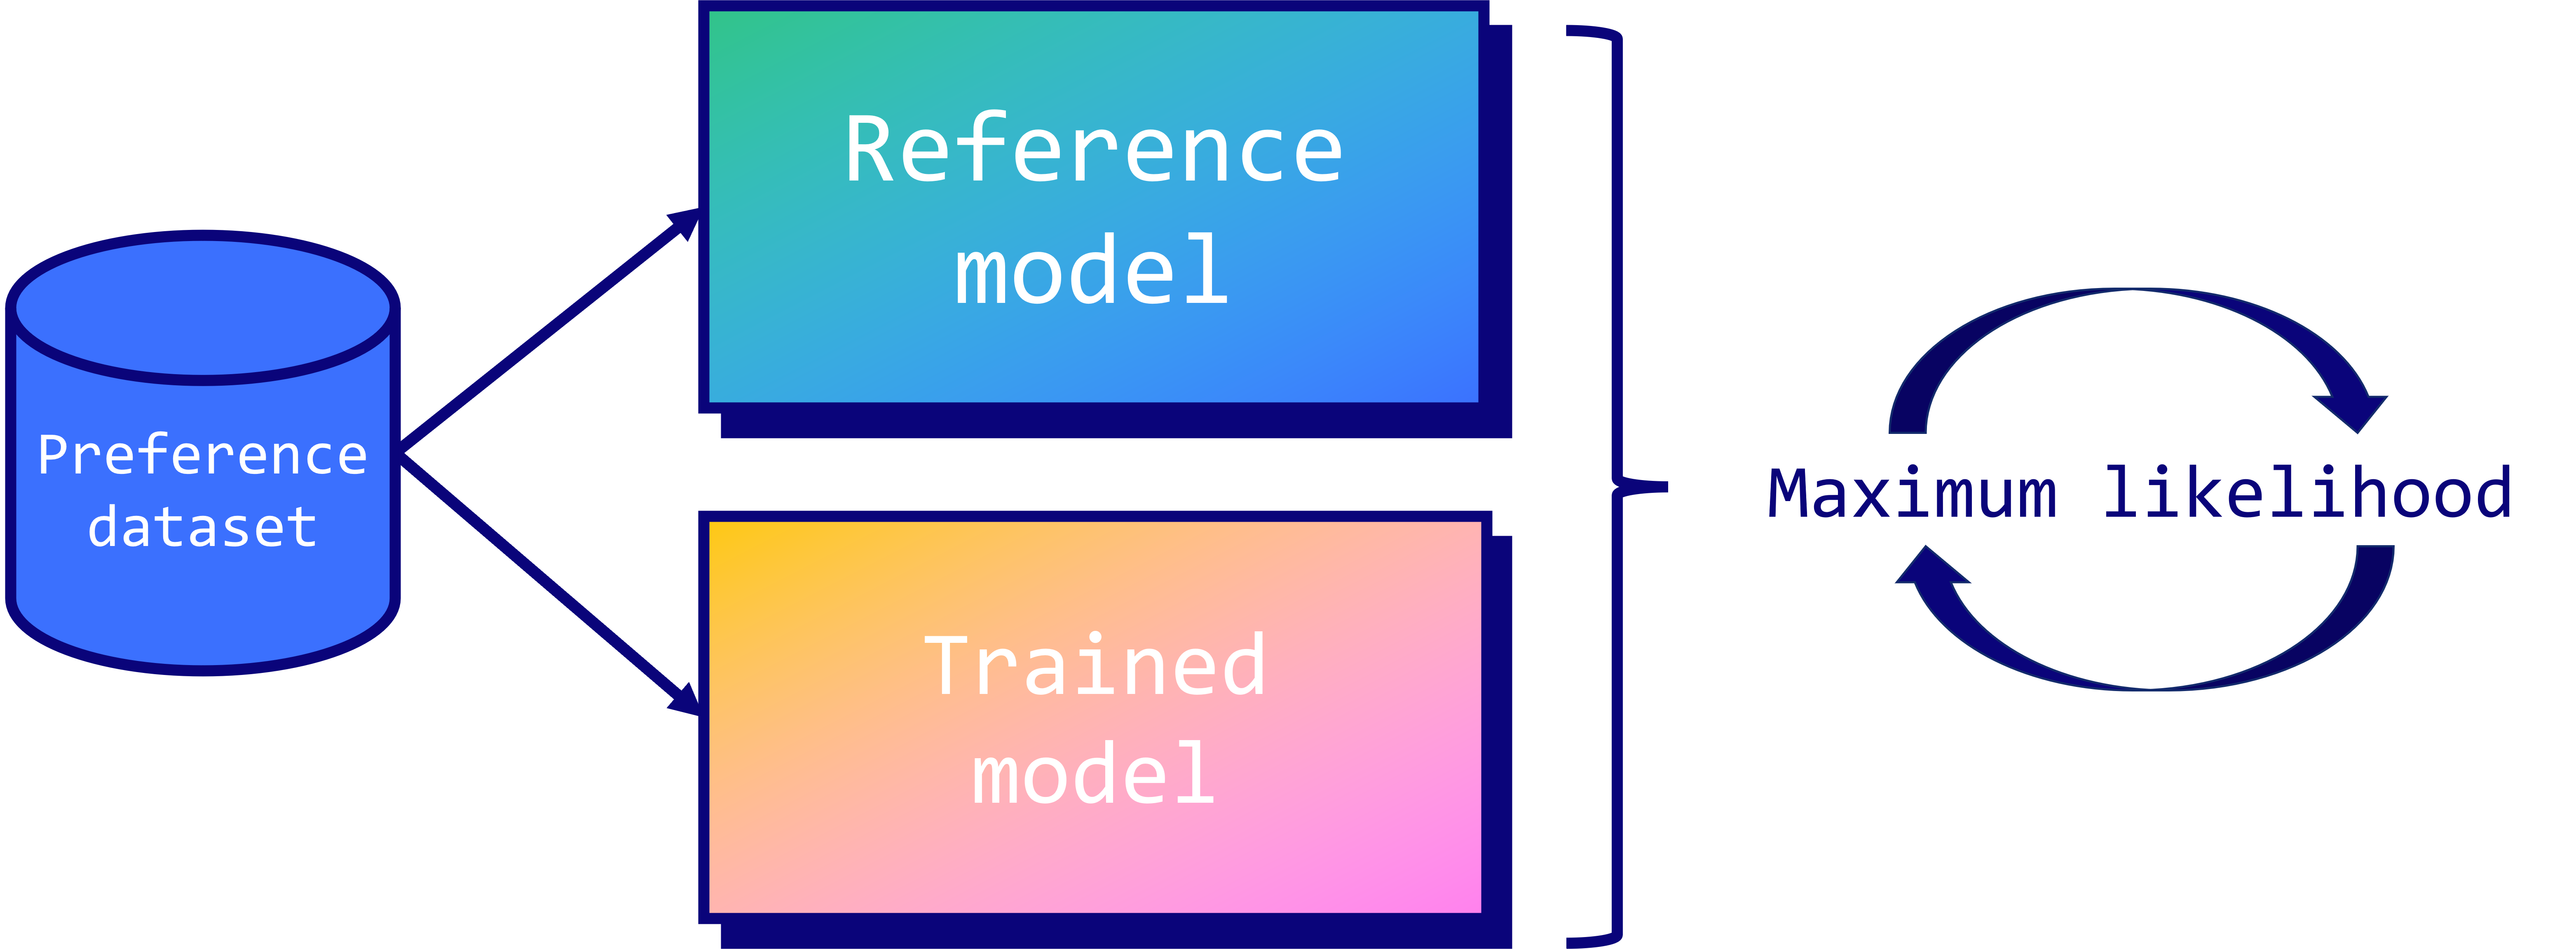

## Import Libraries

In [ ]:
# SPDX-FileCopyrightText: Copyright (c) 2024 NVIDIA CORPORATION & AFFILIATES. All rights reserved.
# SPDX-License-Identifier: Apache-2.0
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import gc
import torch
import transformers
from transformers import (
    AutoModelForCausalLM, 
    AutoTokenizer, 
    TrainingArguments, 
    BitsAndBytesConfig
)
from datasets import load_dataset
from peft import (
    LoraConfig, 
    PeftModel, 
    get_peft_model, 
    prepare_model_for_kbit_training
)
from trl import DPOTrainer, setup_chat_format
import bitsandbytes as bnb

## Load the model and tokenizer

Note that we also load in a reference model. This is for completeness. If we did not provide one, the DPOTrainer will automatically create one for us

In [ ]:
base_model = "meta-llama/Meta-Llama-3-8B-Instruct"
new_model = "/project/models/NV-DPOLlama-3-8B"

In [ ]:
# The bits and bytes config we use for quantization
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(base_model, token=os.environ["HF_KEY"])
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    token=os.environ["HF_KEY"], 
    cache_dir="/project/models",
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config,
    device_map="auto",
)
# Reference model
ref_model = AutoModelForCausalLM.from_pretrained(
    base_model,
    token=os.environ["HF_KEY"], 
    cache_dir="/project/models",
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config,
    device_map="auto",
)

In [ ]:
# LoRA configuration
peft_config = LoraConfig(
    r=16,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=['k_proj', 'gate_proj', 'v_proj', 'up_proj', 'q_proj', 'o_proj', 'down_proj']
)

## Load and format dataset

Preference datasets are a little unique as explained above. Let's take a closer look.

In [ ]:
# Load dataset
dataset = load_dataset("Intel/orca_dpo_pairs")['train']

In [ ]:
# In this notebook we use a subset of 150 samples. In order to do a full tune, you can use around 1000 or the entire dataset
# The seed allows for reproducability. If you run this notebook exactly, you will use the same 150 samples as me
dataset = dataset.shuffle(seed=42).select(range(150))

In [ ]:
dataset

Preference datasets contain the original prompt along with `chosen` and `rejected` columns. These are our preferences. We want the model to respond in a certain way. We can tinker around specific examples in the dataset to reason about why different answers were rejected or chosen!

In [ ]:
dataset[19]['question']

In [ ]:
dataset[19]['rejected']

In [ ]:
dataset[19]['chosen']

Now we format the dataset in order to follow the Llama3 format using the included chat templates (credit: chujiezheng)

In [ ]:
chat_template = open('chat_template/llama-3-instruct.jinja').read()
chat_template = chat_template.replace('    ', '').replace('\n', '')
tokenizer.chat_template = chat_template

In [ ]:
def dataset_format(example):
    # Format system
    if len(example['system']) > 0:
        message = {"role": "system", "content": example['system']}
        system = tokenizer.apply_chat_template([message], tokenize=False)
    else:
        system = ""
    # Format instruction
    message = {"role": "user", "content": example['question']}
    prompt = tokenizer.apply_chat_template([message], tokenize=False, add_generation_prompt=True)
    # Format chosen answer
    chosen = example['chosen'] + "<|eot_id|>\n"
    # Format rejected answer
    rejected = example['rejected'] + "<|eot_id|>\n"
    return {
        "prompt": system + prompt,
        "chosen": chosen,
        "rejected": rejected,
    }

In [ ]:
original_columns = dataset.column_names
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

dataset = dataset.map(
    dataset_format,
    remove_columns=original_columns,
    num_proc= os.cpu_count(),
)

In [ ]:
# notice the specific llama3 tags like <|eot_id|> which show that the chat template formatting worked
dataset[19]

## Create the DPO trainer

(Optional) You can monitor this training run with Weights and Biases. Uncomment the following cell and provide your API key to login.

In [ ]:
### Uncomment to use Weights and Biases ###

# import wandb

# wandb.login()

In [ ]:
training_args = TrainingArguments(
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    gradient_checkpointing=True,
    learning_rate=5e-5,
    lr_scheduler_type="cosine",
    max_steps=200, #tweak this to change # of steps in the training run
    save_strategy="no",
    logging_steps=1,
    output_dir=new_model,
    optim="paged_adamw_32bit",
    warmup_steps=10,
    bf16=True,
    report_to="none", # can replace with "wandb"
)

In [ ]:
dpo_trainer = DPOTrainer(
    model,
    ref_model,
    args=training_args,
    train_dataset=dataset,
    tokenizer=tokenizer,
    peft_config=peft_config,
    beta=0.1,
    max_prompt_length=512,
    max_length=1024, 
    force_use_ref_model=True
)

In [ ]:
# Fine-tune model with DPO
dpo_trainer.train()

## Analyze training run 

Lets take a deeper look at our training run. Specifically, the `train/rewards/chosen, train/rewards/rejected`. This plot corresponds to the mean difference between the log probabilities output by the trained and reference model. Notice that over time they diverge which shows that the model is learning the preferred answer type. 

Additionally, take a look at the `train/reward/accuracies` graph which shows frequency of choosing preferred answer. This could be a good sign but could also mean that the difference between the chosen and rejected answer in our dataset is too obvious.

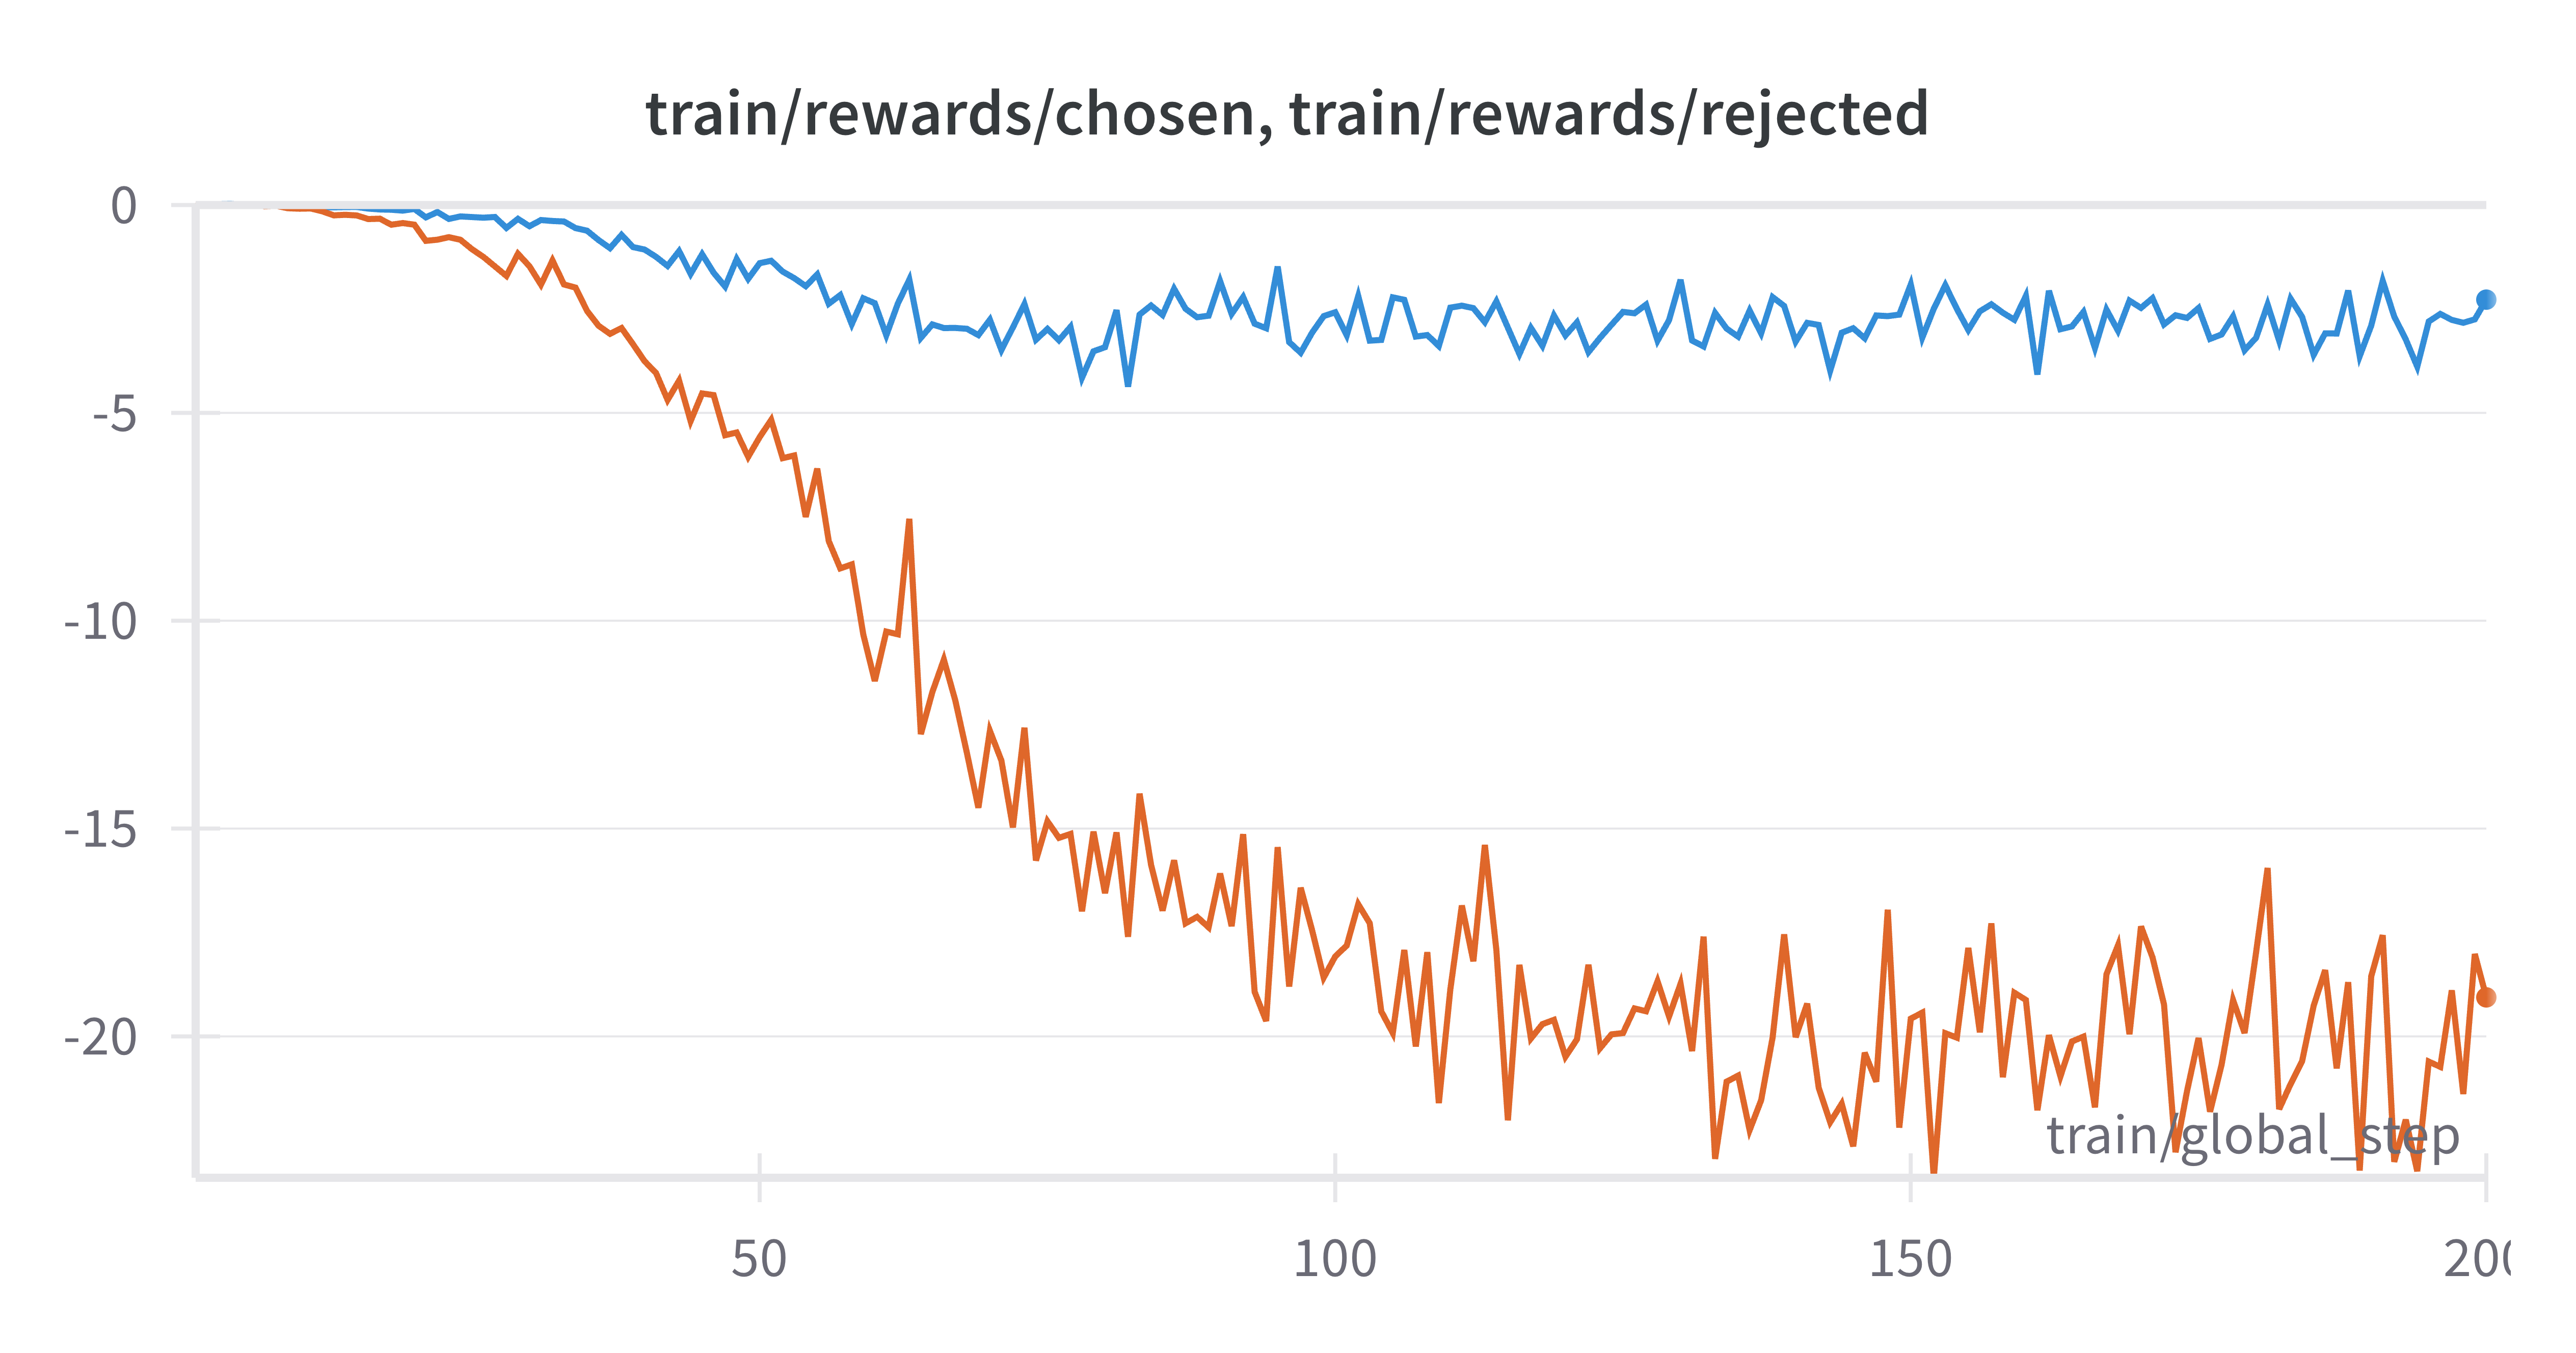

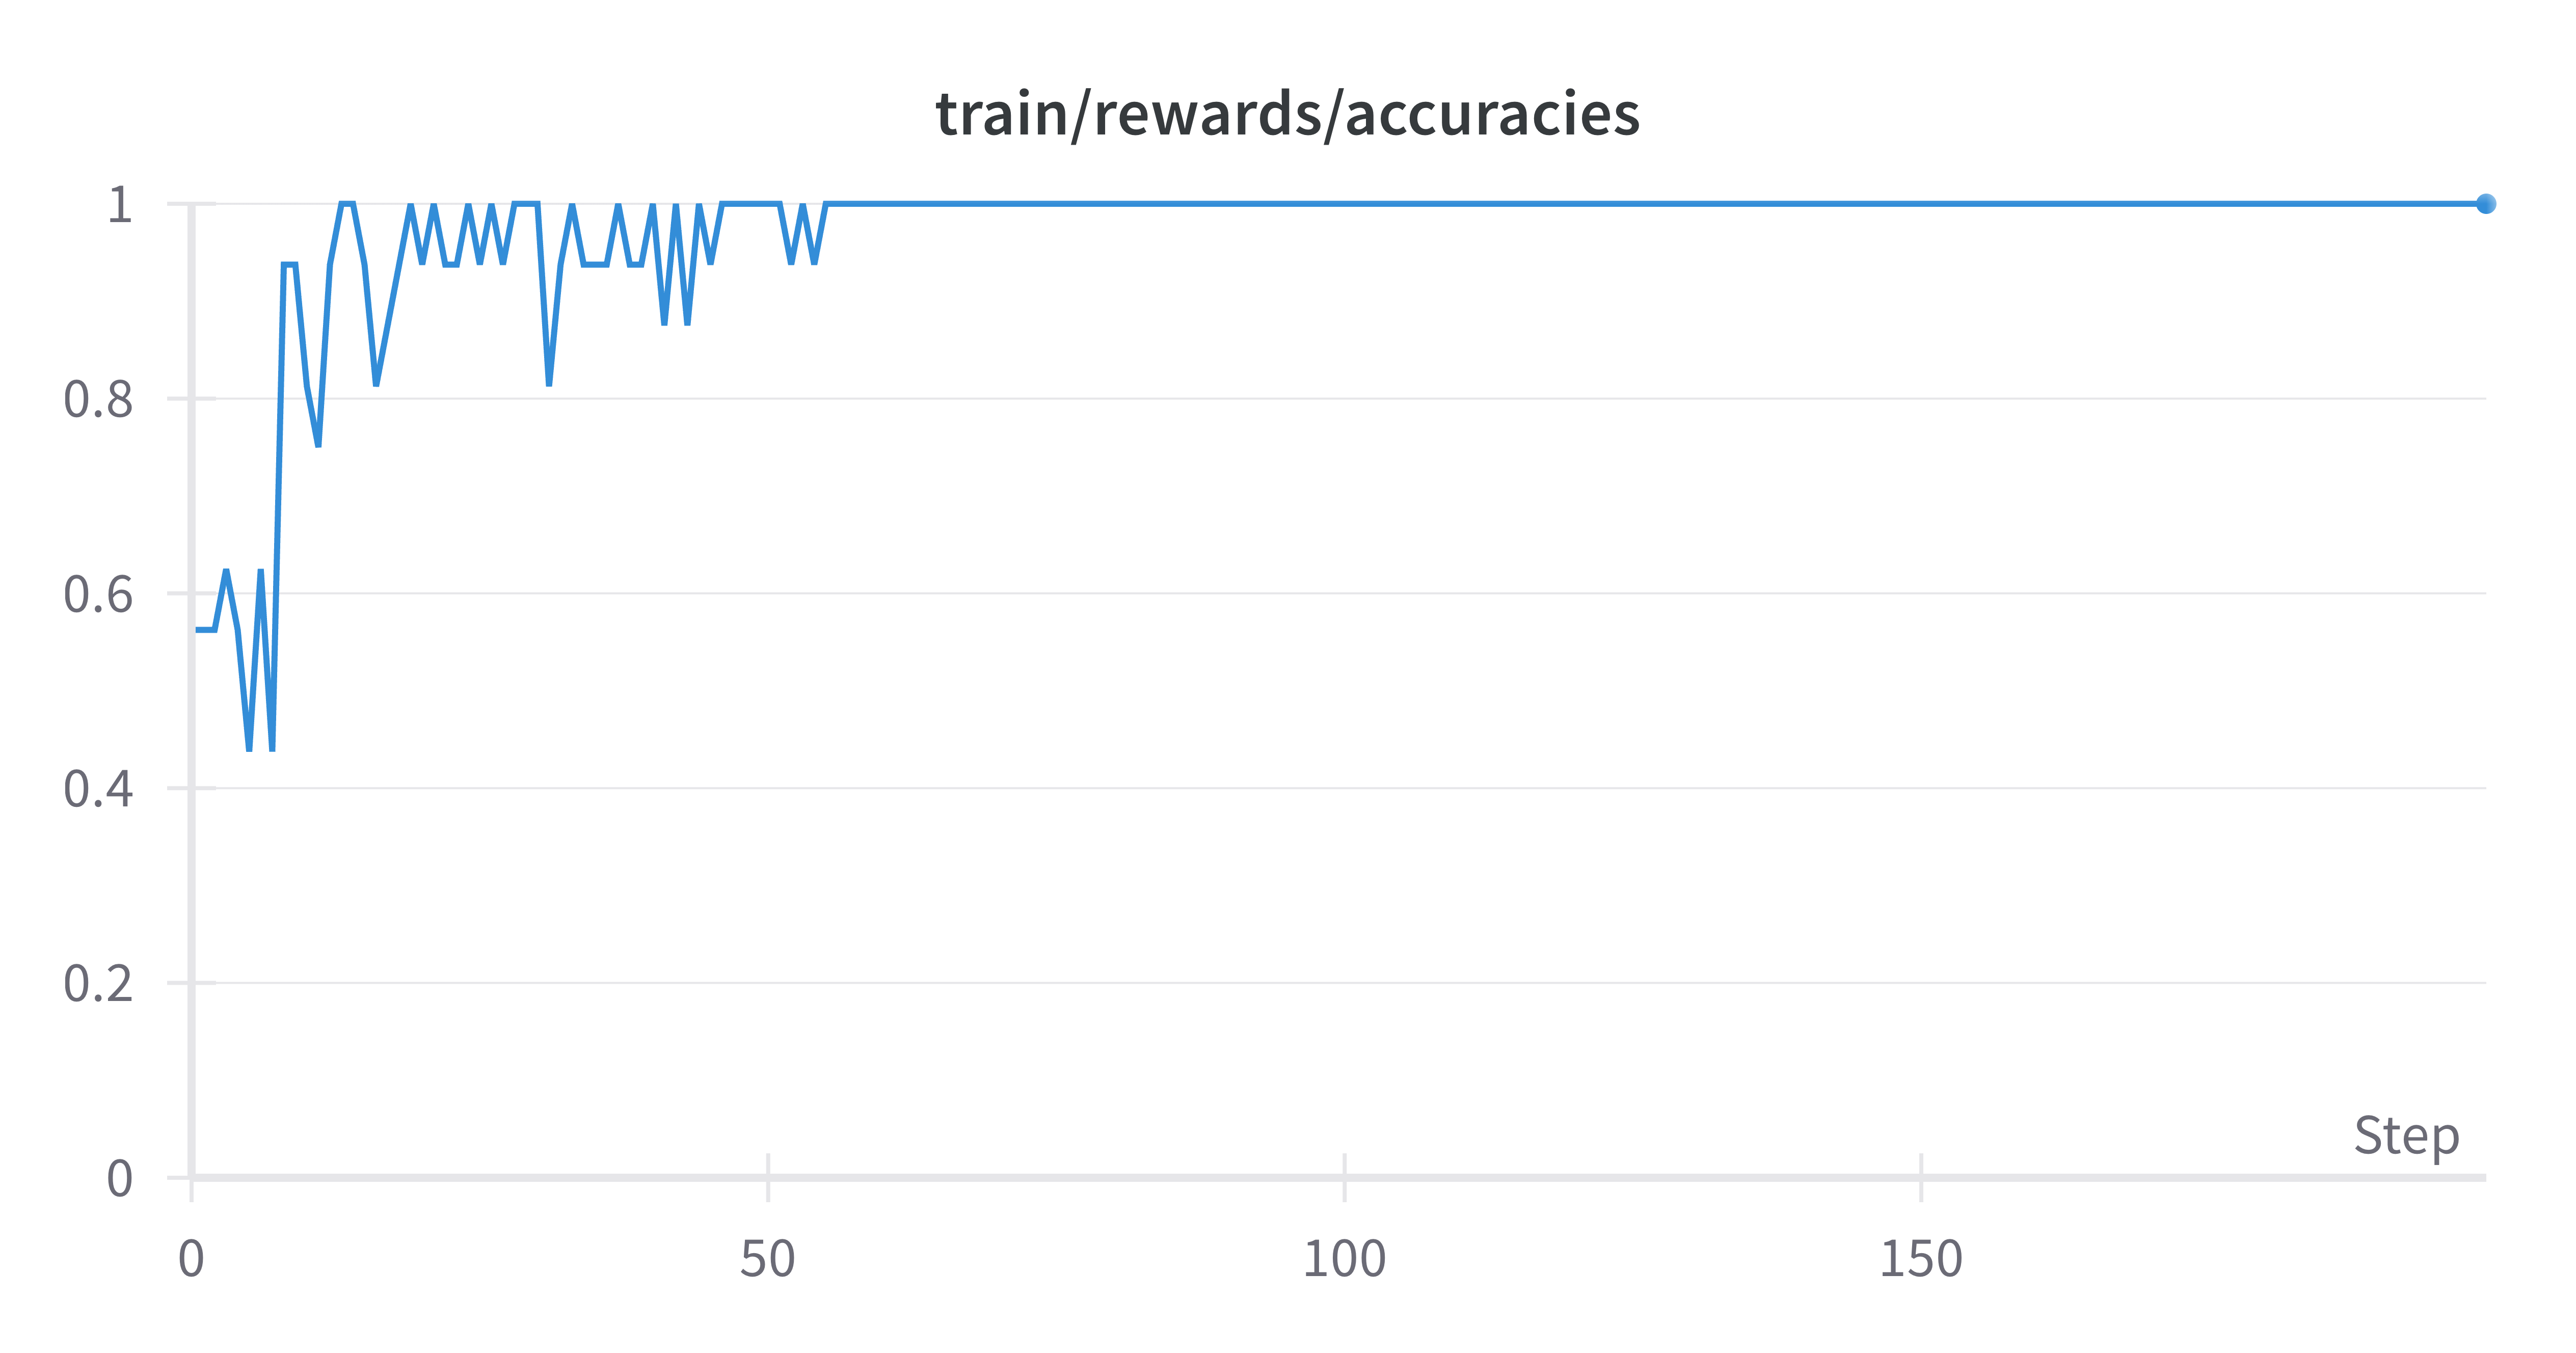

## Save and test model

In [ ]:
from huggingface_hub import login

login(token=os.environ["HF_KEY"]) # Gets rid of token warning
dpo_trainer.model.save_pretrained("final_ckpt")

In [ ]:
tokenizer.save_pretrained("final_ckpt")

In [ ]:
# Flush memory
del dpo_trainer, model, ref_model
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# Reload model in FP16 (instead of NF4)
base_model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Meta-Llama-3-8B-Instruct",
    token=os.environ["HF_KEY"], 
    cache_dir="/project/models",
    return_dict=True,
    torch_dtype=torch.float16,
)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-8B-Instruct", token=os.environ["HF_KEY"])
tokenizer.chat_template = chat_template

In [ ]:
# Merge base model with the adapter
model = PeftModel.from_pretrained(base_model, "final_ckpt")
model = model.merge_and_unload()

# Save model and tokenizer
tokenizer.save_pretrained(new_model)
model.save_pretrained(new_model)

In [ ]:
# Create pipeline
pipeline = transformers.pipeline(
    "text-generation",
    model=new_model,
    tokenizer=tokenizer
)

In [ ]:
# Format prompt
message = [
    {"role": "system", "content": "You are a helpful assistant chatbot that provides concise answers."},
    {"role": "user", "content": "What are GPUs and why would I use them for machine learning tasks?"}
]
tokenizer = AutoTokenizer.from_pretrained(new_model)
prompt = tokenizer.apply_chat_template(message, add_generation_prompt=True, tokenize=False)

# Generate text
sequences = pipeline(
    prompt,
    do_sample=True,
    temperature=0.7,
    top_p=0.9,
    num_return_sequences=1,
    max_length=200,
)
print(sequences[0]['generated_text'])